# Goal
Every year, approximately 7.6 million companion animals end up in US shelters. Many animals are given up as unwanted by their owners, while others are picked up after getting lost or taken out of cruelty situations. Many of these animals find forever families to take them home, but just as many are not so lucky. 2.7 million dogs and cats are euthanized in the US every year.

Using a dataset of intake information including breed, color, sex, and age from the Austin Animal Center, we're asking Kagglers to predict the outcome for each animal.

We also believe this dataset can help us understand trends in animal outcomes. These insights could help shelters focus their energy on specific animals who need a little extra help finding a new home. We encourage you to publish your insights on Scripts so they are publicly accessible.

# Import Data, libraries...
Kaggle.com for datasets

In [1]:
# !pip install pandas_profiling
# !pip install autopep8

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from pandas_profiling import ProfileReport
import re, math

from sklearn import datasets
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score


In [3]:
%matplotlib inline

In [4]:
train = pd.read_csv('data/train.csv', parse_dates=['DateTime'])

# Exploratory Data Analysis

In [5]:
def convert_age(col):
    try:
        age = str(col).split(' ')
        if (age[1] == 'year') | (age[1] == 'years'):
            return float(age[0])
        elif (age[1] == 'month') | (age[1] == 'months'):
            return float(age[0]) / 12
        elif (age[1] == 'week') | (age[1] == 'weeks'):
            return float(age[0]) / 52
        elif (age[1] == 'day') | (age[1] == 'days'):
            return float(age[0]) / 365.25
        else:
            return 0
    except:
        pass
train['AgeInYearsUponOutcome'] = train['AgeuponOutcome'].apply(convert_age)

In [6]:
# remove empty age records
train = train[~train.AgeInYearsUponOutcome.isnull()]

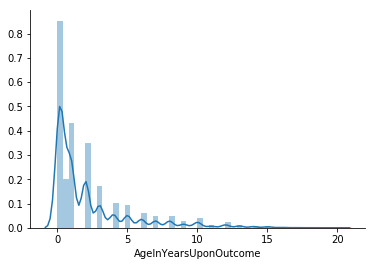

In [7]:
sns.distplot(train.AgeInYearsUponOutcome.dropna())
sns.despine()

In [8]:
train.DateTime[0]

Timestamp('2014-02-12 18:22:00')

In [9]:
train.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,AgeInYearsUponOutcome
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White,1.000000
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby,1.000000
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White,2.000000
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream,0.057692
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan,2.000000


In [10]:
train.dtypes

AnimalID                         object
Name                             object
DateTime                 datetime64[ns]
OutcomeType                      object
OutcomeSubtype                   object
AnimalType                       object
SexuponOutcome                   object
AgeuponOutcome                   object
Breed                            object
Color                            object
AgeInYearsUponOutcome           float64
dtype: object

In [11]:
!mkdir --parent report
ProfileReport(train).to_file('report/train_data.html',) # export to file

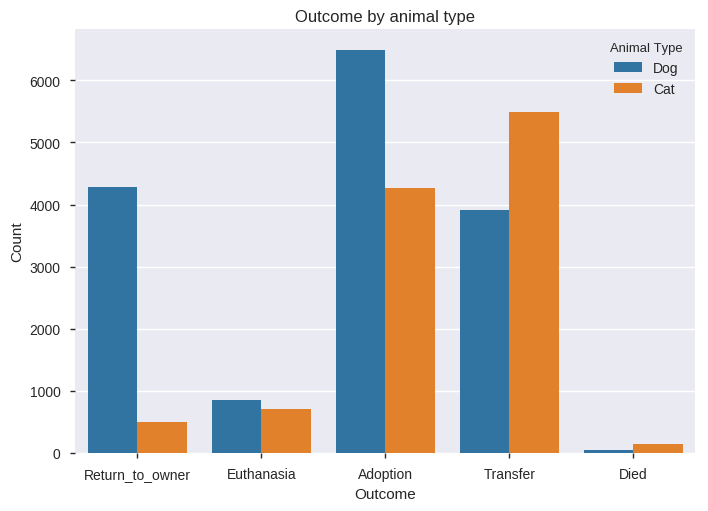

In [12]:
ax = sns.countplot(data = train, x = 'OutcomeType', hue = 'AnimalType')
ax.set_title('Outcome by animal type')
ax.set_xlabel('Outcome')
ax.set_ylabel('Count')
ax.legend_.set_title('Animal Type')

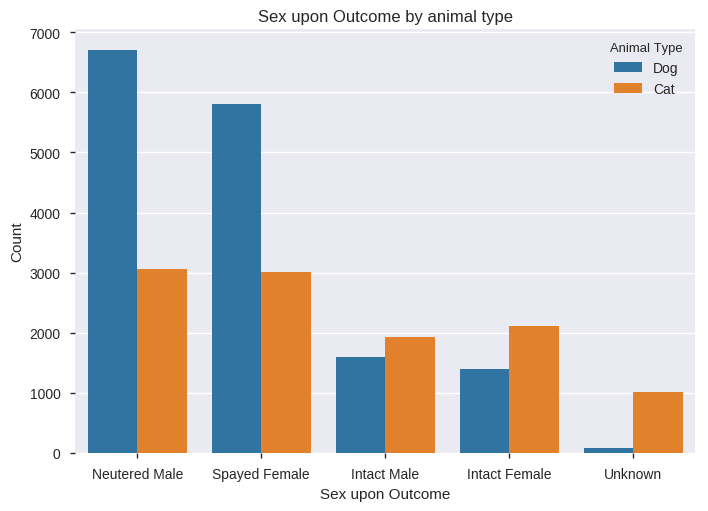

In [13]:
ax = sns.countplot(data = train, x = 'SexuponOutcome', hue = 'AnimalType')
ax.set_title('Sex upon Outcome by animal type')
ax.set_xlabel('Sex upon Outcome')
ax.set_ylabel('Count')
ax.legend_.set_title('Animal Type')

# Feature Engineering

In [14]:
# one-hot encoding of SexuponOutcome
train = pd.get_dummies(train, columns=['SexuponOutcome'] )

# access the year from the datetime col
train['year'] = train.DateTime.dt.year
train['month'] = train.DateTime.dt.month
train['day'] = train.DateTime.dt.day
train['hour'] = train.DateTime.dt.hour
train['minute'] = train.DateTime.dt.minute

# create binary variable has_name if the name isn't empty
train['has_name'] = np.where(train.Name.isnull(), 0, 1).astype(int)

# create binary variable has_mix if the breed has the string 'Mix' in it.
train['has_mix'] = train['Breed'].str.contains('Mix')

In [15]:
train.shape

(26711, 22)

# Decide on Inputs (X) and Output (Y)

In [23]:
trainX = train._get_numeric_data()

In [24]:
# set input variables
# , train['SexuponOutcome_Intact_Female'], train['SexuponOutcome_Intact_Male'], train['SexuponOutcome_Neutered_Male'], train['SexuponOutcome_Spayed_Female'], train['SexuponOutcome_Unknown']
# trainX = train[['AnimalType', 'Breed', 'Color', 'AgeInYearsUponOutcome', 'SexuponOutcome_Unknown', 'SexuponOutcome_Spayed Female']]
# or easy trick is train.
# set output variable
trainY = train.OutcomeType

# Split the data

In [17]:
# split data into test/train

# Decide on the estimator / algorithm + hyperparameters (sklearn)

In [28]:
trainModel = RandomForestClassifier()
trainParameters = { 'max_depth': [4], 'max_features': [ 'auto', 'log2', None, 1, 2, 3, 0.5, 0.25 ] }
trainModel.fit(trainX,trainY)

/home/farida/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

# Fit (train) the learner

In [29]:
clf = GridSearchCV(trainModel, trainParameters, cv=5)
clf.fit(trainX, trainY)
print(clf.best_params_)

{'max_depth': 4, 'max_features': None}


# Predict